In [1]:
import pandas as pd 
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
from keras.models import Model
from keras.layers import Dense, Input, BatchNormalization, ReLU, Softmax, Dropout
from keras.models import load_model
from tensorflow.keras import initializers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Step1.) Load and discover the dataset

In [2]:
df = pd.read_csv('as1-bank.csv')
print("Dataframe dimensions : ",df.shape)
df.head(8)

Dataframe dimensions :  (7842, 14)


,age,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,33,1,2,no,882,no,no,1,39,1,151,3,0,no
1,42,0,1,no,-247,yes,yes,1,519,1,166,1,2,yes
2,33,1,1,no,3444,yes,no,1,144,1,91,4,0,yes
3,36,1,2,no,2415,yes,no,1,73,1,86,4,2,no
4,36,1,2,no,0,yes,no,1,140,1,143,3,0,yes
5,44,1,1,no,1324,yes,no,1,119,1,89,2,2,no
6,26,0,2,no,172,no,yes,1,21,1,140,4,2,no
7,51,0,1,no,3132,no,no,1,449,1,176,1,0,no


In [3]:
df.describe()

,age,marital,education,balance,contact,duration,campaign,pdays,previous,poutcome
count,7842.000000,7842.000000,7842.000000,7842.000000,7842.000000,7842.000000,7842.000000,7842.000000,7842.000000,7842.000000
mean,40.783856,0.800179,1.206707,1552.343280,0.074598,261.290615,2.064269,223.252869,3.184264,0.626498
std,11.282964,0.621418,0.649716,3084.580003,0.262759,236.203272,1.566109,111.830127,4.614190,0.824863
min,18.000000,0.000000,0.000000,-1884.000000,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000
25%,32.000000,0.000000,1.000000,162.000000,0.000000,113.000000,1.000000,133.000000,1.000000,0.000000
50%,38.000000,1.000000,1.000000,595.000000,0.000000,194.000000,2.000000,195.000000,2.000000,0.000000
75%,47.000000,1.000000,2.000000,1733.750000,0.000000,324.000000,2.000000,326.000000,4.000000,1.000000
max,89.000000,2.000000,2.000000,81204.000000,1.000000,2219.000000,16.000000,871.000000,275.000000,2.000000


#### Check the data types of the features
Data types that are of type 'object' (education, housing, loan) including the target variable y, will need to be converted in numerical form. 

In [4]:
df.dtypes

age           int64
marital       int64
education     int64
default      object
balance       int64
housing      object
loan         object
contact       int64
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome      int64
y            object
dtype: object

#### Check for missing / Null values
The dataset does not contain missing values, so no problems will arise while feeding the data to our networks.

In [5]:
print(df.isnull().any())

age          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool


#### We can see that the dataset is unbalanced, only 22.8% of the data points are assigned to class y='yes'. This might pose a problem in performance.

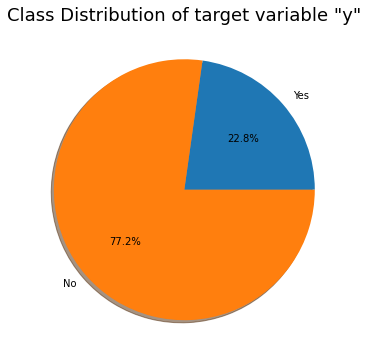

In [6]:
yes = len(df[df['y'] == 'yes'])
no = len(df[df['y'] == 'no'])

fig, ax = plt.subplots(figsize=(6,6))
plt.pie(x=[yes, no], labels=['Yes','No'], shadow=True, autopct='%1.1f%%')
plt.title('Class Distribution of target variable "y"', fontsize=18)
plt.show()

## Step2.) Pre-process dataset 
- Convert categorical variables into numerical variables 
- drop very low correlated with target variable features (lower than 0.1).
- Normalize the dataset 
- Split into train-val-test subsets 
- Convert feature data to tensors.

In [7]:
from sklearn import preprocessing

def categorical_to_numerical(feat) : 
    le = preprocessing.LabelEncoder()
    encoded_feat = le.fit_transform(feat)
    return encoded_feat 

In [8]:
df.y = categorical_to_numerical(df.y)
df.default = categorical_to_numerical(df.default)
df.housing = categorical_to_numerical(df.housing)
df.loan = categorical_to_numerical(df.loan)
## Dataframe after converting the values to numerical
print("Dataframe data types AFTER encoding : \n", df.dtypes)
df

Dataframe data types AFTER encoding : 
 age          int64
marital      int64
education    int64
default      int32
balance      int64
housing      int32
loan         int32
contact      int64
duration     int64
campaign     int64
pdays        int64
previous     int64
poutcome     int64
y            int32
dtype: object


,age,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,33,1,2,0,882,0,0,1,39,1,151,3,0,0
1,42,0,1,0,-247,1,1,1,519,1,166,1,2,1
2,33,1,1,0,3444,1,0,1,144,1,91,4,0,1
3,36,1,2,0,2415,1,0,1,73,1,86,4,2,0
4,36,1,2,0,0,1,0,1,140,1,143,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7837,34,0,1,0,1475,1,0,0,1166,3,530,12,2,0
7838,53,1,2,0,583,0,0,0,226,1,184,4,1,1
7839,73,1,1,0,2850,0,0,0,300,1,40,8,0,1
7840,72,1,1,0,5715,0,0,0,1127,5,184,3,1,1


#### Spearman correlation Matrix

In [9]:
# Fill diagonal and upper half with NaNs
corr = df.corr(method='spearman')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='cool', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#eee')  # Color NaNs grey
 .set_precision(3))

C:\Users\Konpoul\AppData\Local\Temp/ipykernel_20832/2351298829.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,age,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
age,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
marital,0.471,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
education,-0.158,-0.142,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
default,-0.027,-0.000,-0.013,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
balance,0.087,0.004,0.091,-0.109,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
housing,-0.103,0.051,-0.122,0.021,-0.155,nan,nan,nan,nan,nan,nan,nan,nan,nan
loan,0.020,0.061,-0.035,0.049,-0.122,0.104,nan,nan,nan,nan,nan,nan,nan,nan
contact,0.142,0.026,-0.093,-0.018,0.045,-0.078,-0.035,nan,nan,nan,nan,nan,nan,nan
duration,0.026,0.005,-0.005,-0.021,0.077,-0.126,-0.037,-0.023,nan,nan,nan,nan,nan,nan
campaign,0.014,0.019,-0.038,-0.003,-0.020,0.061,0.014,0.100,-0.096,nan,nan,nan,nan,nan


In [10]:
df = df.drop(columns = [ 'age', 'marital','default', 'contact', 'campaign', 'previous'], axis=1)
df

,education,balance,housing,loan,duration,pdays,poutcome,y
0,2,882,0,0,39,151,0,0
1,1,-247,1,1,519,166,2,1
2,1,3444,1,0,144,91,0,1
3,2,2415,1,0,73,86,2,0
4,2,0,1,0,140,143,0,1
...,...,...,...,...,...,...,...,...
7837,1,1475,1,0,1166,530,2,0
7838,2,583,0,0,226,184,1,1
7839,1,2850,0,0,300,40,0,1
7840,1,5715,0,0,1127,184,1,1


#### Normalize all features with Min-Max scaling but leave the label y untouched. 

## $ Standard\_Scaling = \frac{X - \bar{X}}{S} $ ,
where $\bar{X}$ is the mean value of a feature X and S it's variance.

In [11]:
#mm = preprocessing.MinMaxScaler()
mm= preprocessing.StandardScaler()
y = df.y  # label values
X = df.drop('y', axis=1) # features
X_norm = mm.fit_transform(X)
## Dataframe after normalizing
print("Feature data types AFTER normalizing : \n", X_norm.dtype)
# First row of feature array 
print("\n Feature values after normalizing (first row) : \n", X_norm[0])

# Other ways with pandas only
# norm_df=(df-df.mean())/df.std()  #Standard Scale
# normalized_df=(df-df.min())/(df.max()-df.min()) #Mini Max

Feature data types AFTER normalizing : 
 float64

 Feature values after normalizing (first row) : 
 [ 1.22106157 -0.21733462 -1.30542634 -0.40157398 -0.94115881 -0.64613605
 -0.75956611]


#### Split into train-val-test with a 60-20-20 rule and convert dataframe to tensors so that network can be trained.

In [12]:
from sklearn.model_selection import train_test_split
def split_dataset(X, y) : 
    # 60% of dataset for training and 40% for val-test subsets
    X_train, X_sub, y_train, y_sub = train_test_split( X, y, test_size=0.4, shuffle=True) 
    # half of the initital 40%  as validation and the other hald as test set.
    X_val, X_test, y_val, y_test = train_test_split(X_sub, y_sub, test_size=0.5, shuffle=True, random_state=None)
    
    # Convert dataframes to tensors
    X_train_tensors = tf.convert_to_tensor(X_train)
    X_val_tensors = tf.convert_to_tensor(X_val)
    X_test_tensors = tf.convert_to_tensor(X_test)

    print(f" TRAIN set dimensions  X_train:{X_train.shape}, y_train:{y_train.shape} ")
    print(f" VALIDATION set dimensions  X_val:{X_val.shape}, y_val:{y_val.shape} ")
    print(f" TEST set dimensions  X_test:{X_test.shape}, y_test:{y_test.shape} ")
    
    return X_train_tensors, X_val_tensors, X_test_tensors, y_train, y_val, y_test

In [13]:
X_train_tensors, X_val_tensors, X_test_tensors, y_train, y_val, y_test = split_dataset(X_norm, y)

 TRAIN set dimensions  X_train:(4705, 7), y_train:(4705,) 
 VALIDATION set dimensions  X_val:(1568, 7), y_val:(1568,) 
 TEST set dimensions  X_test:(1569, 7), y_test:(1569,) 


## step3.) Design Neural Networks .
- assign callback functions for imrpoved training
- design network
- fit network
- plot graph loss 
- evaluate network

In [14]:
def assign_callbacks(weights_file,patience,lr_factor):
  return[
      #Only save the weights that correspond to the minimum validation loss.
      tf.keras.callbacks.ModelCheckpoint(filepath=weights_file,
                                         monitor='val_accuracy',
                                         mode='max',
                                         save_best_only=True ,
                                         save_weights_only=False,
                                         verbose=0),
      #If val_loss doesn't improve for a number of epochs set with 'patience' 
      #variable, training will stop to avoid overfitting.    
      tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=patience,
                                       verbose=1),
      #Learning rate is reduced by 'lr_factor' if val_loss stagnates
      #for a number of epochs set with 'patience/2' variable.
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                           mode='min',
                                           factor=lr_factor,
                                           patience=patience//2,
                                           min_lr=1e-6,
                                           verbose=1)]

In [15]:
def loss_curves(history, name='Model', figsize=(16,8)) : 
    
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    # summarize history for loss
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title(f'{name} loss', fontsize=16)
    ax[0].set_ylabel('loss', fontsize=12)
    ax[0].set_xlabel('epoch', fontsize=12)
    #ax[0].set_yticks(np.arange(0.25, 0.45, 0.05))
    ax[0].legend(['train', 'val'], loc='lower left', fontsize=12)

    # summarize history for accuracy
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title(f'{name} accuracy', fontsize=16)
    ax[1].set_ylabel('accuracy', fontsize=12)
    ax[1].set_xlabel('epoch', fontsize=12)
    #ax[1].set_yticks(np.arange(0.7, 0.9, 0.025))
    ax[1].legend(['train', 'val'], loc='lower left', fontsize=12)
    
    fig.suptitle(f"Learning curves for {name}", fontsize=20)
    plt.show()

In [16]:
def create_model(input_dim, layers_dim, drop=0.2, batchNorm=False) : 
    ''' layers_dim (list): A list of integers defining the dimensions of each layer'''
    # clear cache for keras backend
    tf.keras.backend.clear_session()

    # Create an object of class keras.Sequential
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=input_dim))
    for dim in layers_dim:
        # Add a Fully connected layer, batch norm and an activation function. 
        #specify output dimension (ie. number of neurons) and activation as ReLU and use Glorot weight initialization.
        model.add(Dense(dim, activation='relu',
                  kernel_initializer= tf.keras.initializers.GlorotNormal(seed=None),    #initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None) ,#,
                  bias_initializer= initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None))) 
        model.add(Dropout(drop))
        if batchNorm :
            model.add(BatchNormalization()) # Batch normalization for better results.
    
    # The final layer (of 1 neuron) acting as a binary classifier.
    model.add(Dense(1, activation='sigmoid'))
    
    # prioritize 'yes' class since it is unblanced with almost 5 to 1 ratio.
    class_weights = {0 : 1, 1 : 5}
    model.compile("SGD", "binary_crossentropy", metrics=["accuracy"])
    return model

In [17]:
def train_model(model, epochs=50, weights_file='Net_Weights/Neural_Net.h5', batches=32, patience=10, lr=0.0003) :
    
    #checkpoint_dir = os.path.dirname(weights_file)

    callbacks = assign_callbacks(weights_file, patience, lr)
    history = model.fit(X_train_tensors, y_train, epochs=epochs, batch_size=batches,
                         validation_data=(X_val_tensors, y_val), callbacks=callbacks,
                         shuffle=True, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    tr_acc = history.history['accuracy'][-1]
    tr_loss = history.history['val_loss'][-1]
    val_loss =history.history['loss'][-1]
    print("------------------"*5)
    print("    TRAINING RESULTS FOR LAST EPOCH    " )
    print(" Training loss : ", round(tr_loss, 4))
    print(" Validation loss : " ,round(val_loss, 4))
    print(" Training accuracy : ", round(tr_acc, 4))
    print(" Validation accuracy : ", round(val_acc, 4))
    print("------------------"*5)
    
    return history

## step4.) Train Networks

#### Model_1 :     1 Hidden layer 

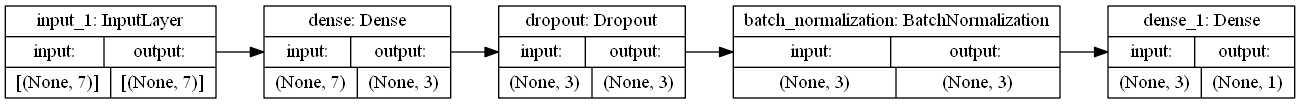

In [18]:
model1 = create_model(X.shape[1], layers_dim=[3], batchNorm=True, drop=0.)
tf.keras.utils.plot_model(model1, show_shapes=True, rankdir="LR")


Epoch 00063: ReduceLROnPlateau reducing learning rate to 2.9999999329447744e-06.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 00068: early stopping
------------------------------------------------------------------------------------------
    TRAINING RESULTS FOR LAST EPOCH    
 Training loss :  0.3955
 Validation loss :  0.3922
 Training accuracy :  0.8083
 Validation accuracy :  0.8048
------------------------------------------------------------------------------------------


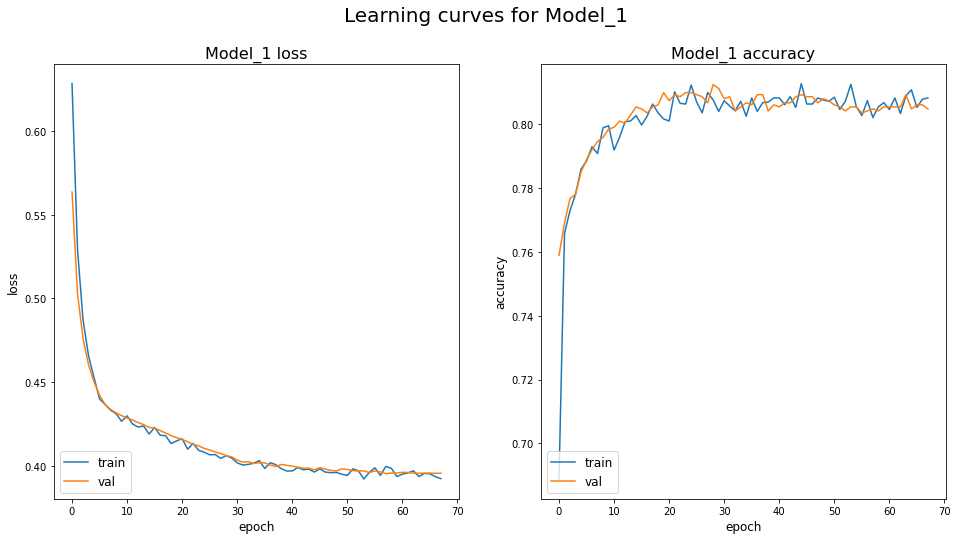

In [19]:
history1 = train_model(model1, batches=32, epochs=200, lr=0.0003, weights_file='Net_Weights/Neural_Net1.h5')
loss_curves(history1, name='Model_1')

#### Model_2 : 1 (bigger) Hidden layer 

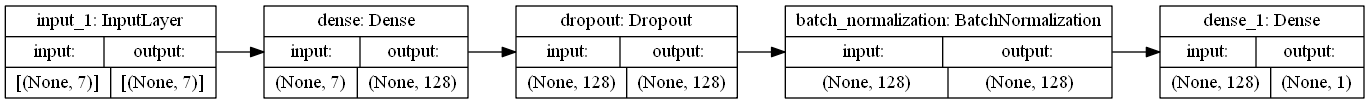

In [22]:
model2 = create_model(X.shape[1], layers_dim=[128], batchNorm=True, drop=0.2)
tf.keras.utils.plot_model(model2, show_shapes=True, rankdir="LR")


Epoch 00035: ReduceLROnPlateau reducing learning rate to 2.9999999329447744e-06.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 00040: early stopping
------------------------------------------------------------------------------------------
    TRAINING RESULTS FOR LAST EPOCH    
 Training loss :  0.351
 Validation loss :  0.3498
 Training accuracy :  0.8436
 Validation accuracy :  0.838
------------------------------------------------------------------------------------------


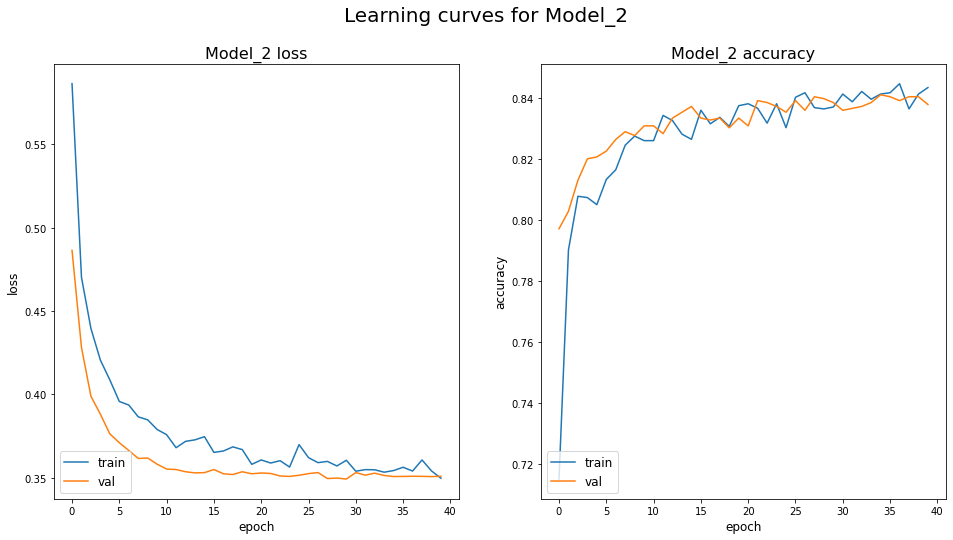

In [23]:
history2 = train_model(model2, batches=32, epochs=200, lr=0.0003, weights_file='Net_Weights/Neural_Net2.h5')
loss_curves(history2, name='Model_2')

#### Model_3 : 2 Hidden layers

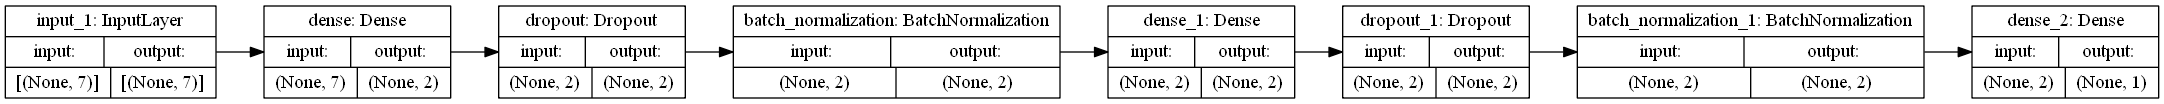

In [24]:
model3 = create_model(X.shape[1], layers_dim=[2, 2], batchNorm=True, drop=0.2)
tf.keras.utils.plot_model(model3, show_shapes=True, rankdir="LR")


Epoch 00093: ReduceLROnPlateau reducing learning rate to 2.9999999329447744e-06.

Epoch 00100: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 00105: early stopping
------------------------------------------------------------------------------------------
    TRAINING RESULTS FOR LAST EPOCH    
 Training loss :  0.4267
 Validation loss :  0.4557
 Training accuracy :  0.7745
 Validation accuracy :  0.7672
------------------------------------------------------------------------------------------


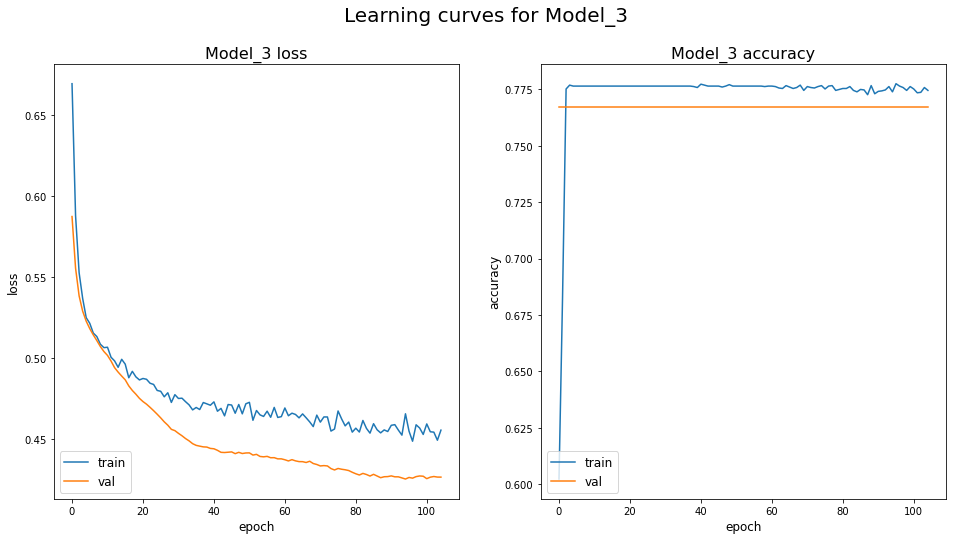

In [25]:
history3 = train_model(model3, batches=32, epochs=200, lr=0.0003, weights_file='Net_Weights/Neural_Net3.h5')
loss_curves(history3, name='Model_3')

#### Model_4 : 2 (Bigger) Hidden layers

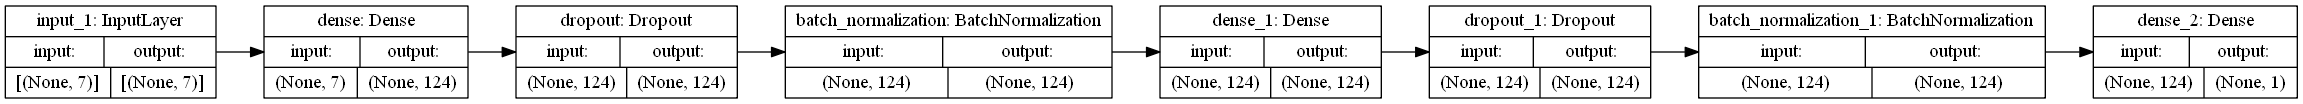

In [26]:
model4 = create_model(X.shape[1], layers_dim=[124, 124], batchNorm=True, drop=0.2)
tf.keras.utils.plot_model(model4, show_shapes=True, rankdir="LR")


Epoch 00032: ReduceLROnPlateau reducing learning rate to 2.9999999329447744e-06.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 00037: early stopping
------------------------------------------------------------------------------------------
    TRAINING RESULTS FOR LAST EPOCH    
 Training loss :  0.3515
 Validation loss :  0.3654
 Training accuracy :  0.8342
 Validation accuracy :  0.8367
------------------------------------------------------------------------------------------


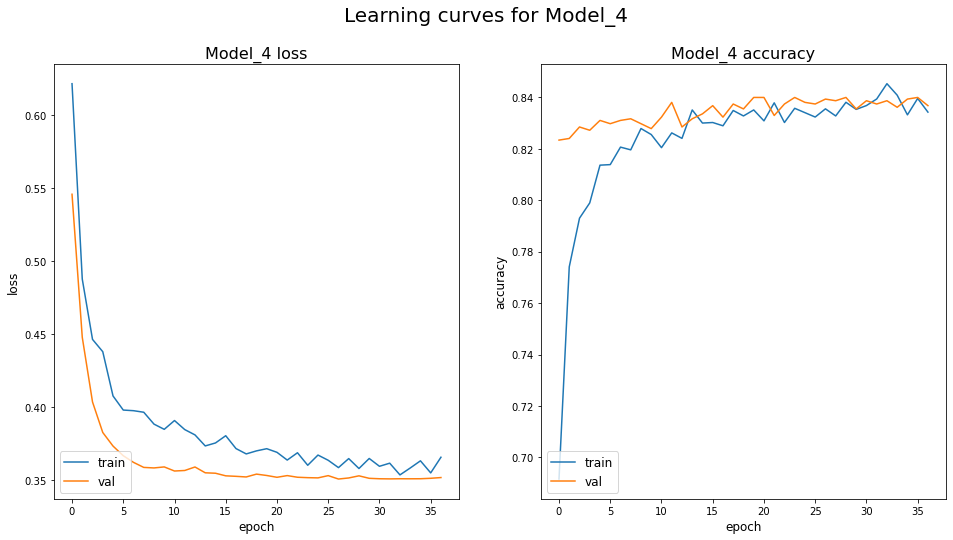

In [27]:
history4 = train_model(model4, epochs=200, batches=32, lr=0.0003, weights_file='Net_Weights/Neural_Net4.h5', patience=10)
loss_curves(history4, name='Model_4')

#### Model_5 : 4 Hidden layers

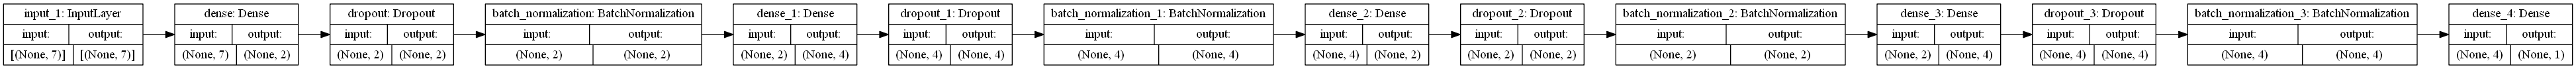

In [28]:
model5 = create_model(X.shape[1], layers_dim=[2, 4, 2, 4], batchNorm=True, drop=0.2)
tf.keras.utils.plot_model(model5, show_shapes=True, rankdir="LR")


Epoch 00008: ReduceLROnPlateau reducing learning rate to 2.9999999329447744e-06.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 00013: early stopping
------------------------------------------------------------------------------------------
    TRAINING RESULTS FOR LAST EPOCH    
 Training loss :  0.5323
 Validation loss :  0.5382
 Training accuracy :  0.7726
 Validation accuracy :  0.7672
------------------------------------------------------------------------------------------


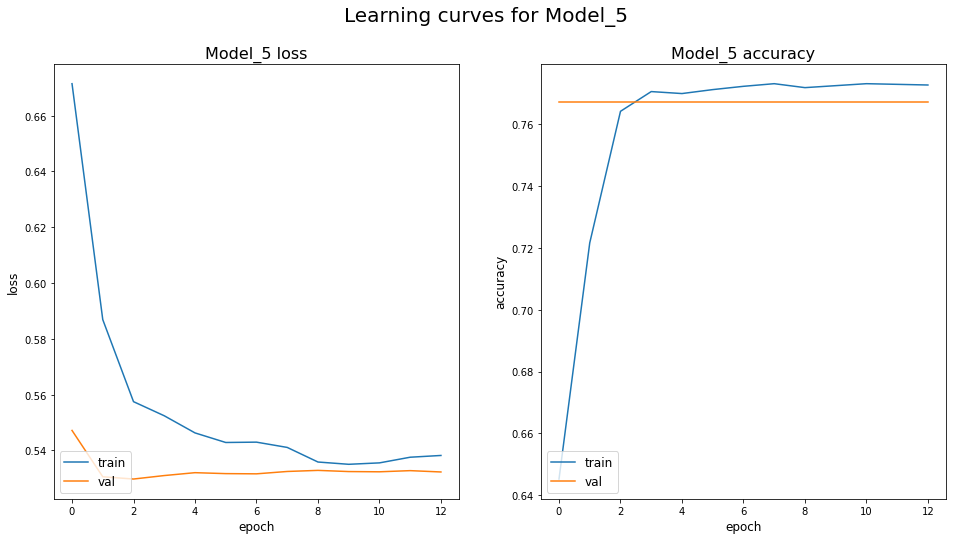

In [29]:
history5 = train_model(model5, batches=32, epochs=200, lr=0.0003, weights_file='Net_Weights/Neural_Net5.h5', patience=10)
loss_curves(history5, name='Model_5')

#### Model_6 : 4 (bigger) Hidden layers

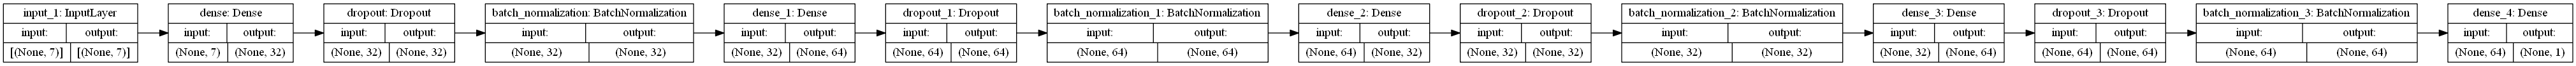

In [30]:
model6 = create_model(X.shape[1], layers_dim=[32, 64, 32, 64], batchNorm=True, drop=0.2)
tf.keras.utils.plot_model(model6, show_shapes=True, rankdir="LR")


Epoch 00043: ReduceLROnPlateau reducing learning rate to 2.9999999329447744e-06.

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 00048: early stopping
------------------------------------------------------------------------------------------
    TRAINING RESULTS FOR LAST EPOCH    
 Training loss :  0.365
 Validation loss :  0.3925
 Training accuracy :  0.8077
 Validation accuracy :  0.8227
------------------------------------------------------------------------------------------


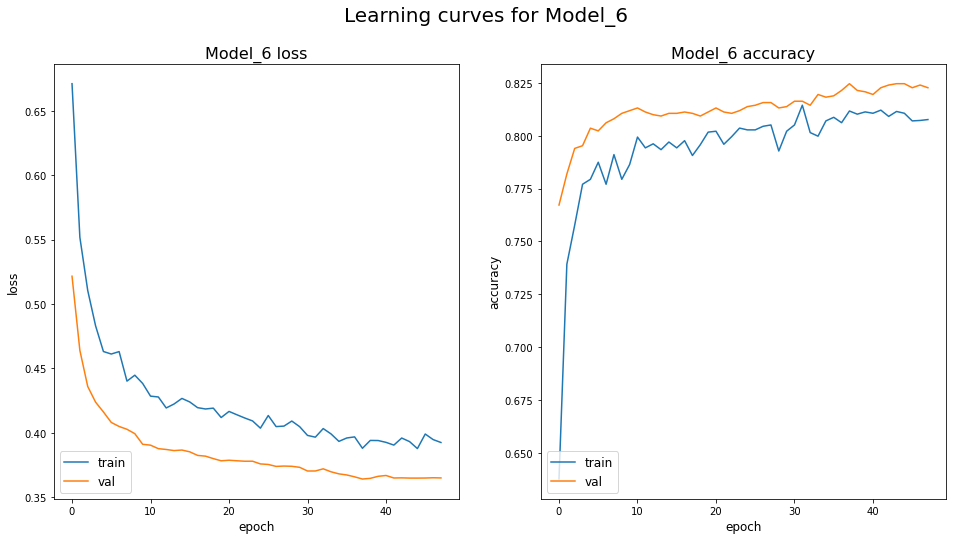

In [31]:
history6 = train_model(model6, batches=32, epochs=200, lr=0.0003, weights_file='Net_Weights/Neural_Net6.h5')
loss_curves(history6, name='Model_6')

#### Model_7 : 10 Hidden layers

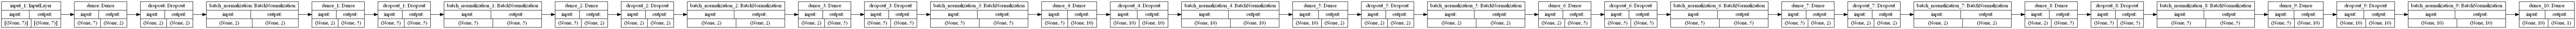

In [32]:
model7 = create_model(X.shape[1], layers_dim=[2,5,2,5,10,2,5,2,5,10], batchNorm=True)
tf.keras.utils.plot_model(model7, show_shapes=True, rankdir="LR")


Epoch 00009: ReduceLROnPlateau reducing learning rate to 2.9999999329447744e-06.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 00014: early stopping
------------------------------------------------------------------------------------------
    TRAINING RESULTS FOR LAST EPOCH    
 Training loss :  0.5441
 Validation loss :  0.5462
 Training accuracy :  0.7753
 Validation accuracy :  0.7672
------------------------------------------------------------------------------------------


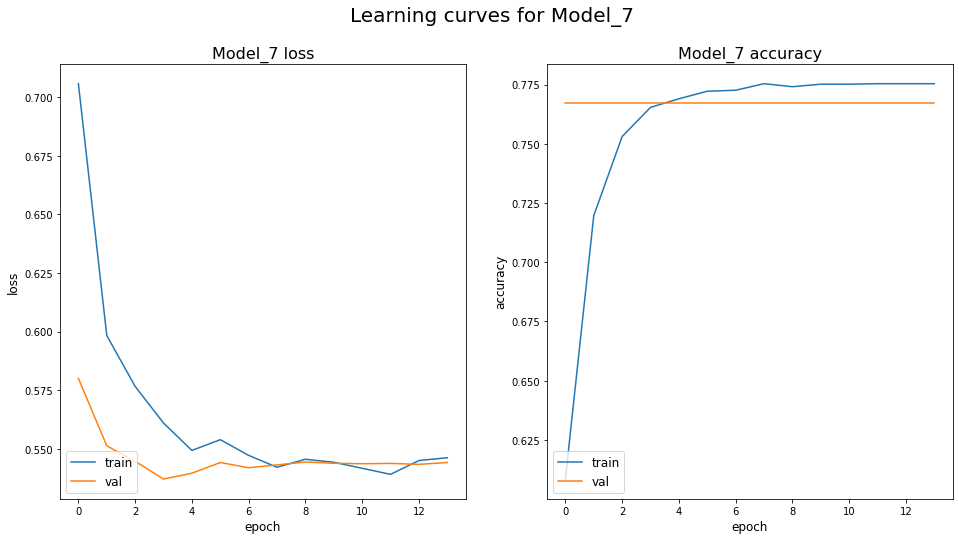

In [33]:
history7 = train_model(model7, batches=32, epochs=200, lr=0.0003, weights_file='Net_Weights/Neural_Net7.h5')
loss_curves(history7, name='Model_7')

## step4.) Evaluate on Test set

#### Model 1 evaluation

------------------------------------------------------------------------------------------------------------------------
50/50 [==============================] - 0s 2ms/step - loss: 0.3955 - accuracy: 0.8260
Test set accuracy=0.826004
Test set loss=0.395487
CONFUSION MATRIX FOR Model_1


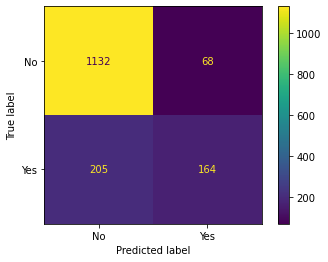

------------------------------------------------------------------------------------------------------------------------
50/50 [==============================] - 0s 2ms/step - loss: 0.3294 - accuracy: 0.8477
Test set accuracy=0.847674
Test set loss=0.329379
CONFUSION MATRIX FOR Model_2


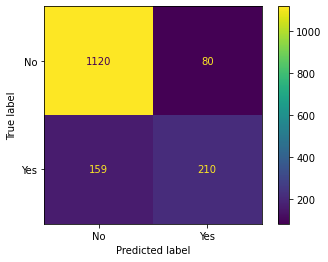

------------------------------------------------------------------------------------------------------------------------
50/50 [==============================] - 0s 3ms/step - loss: 0.5844 - accuracy: 0.7648
Test set accuracy=0.764818
Test set loss=0.584433
CONFUSION MATRIX FOR Model_3


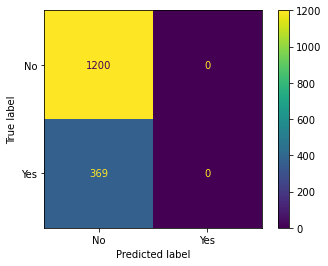

------------------------------------------------------------------------------------------------------------------------
50/50 [==============================] - 0s 3ms/step - loss: 0.3343 - accuracy: 0.8502
Test set accuracy=0.850223
Test set loss=0.334268
CONFUSION MATRIX FOR Model_4


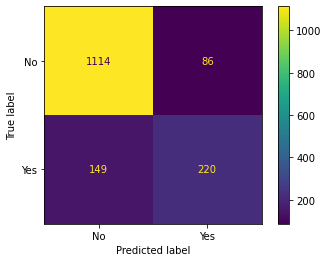

------------------------------------------------------------------------------------------------------------------------
50/50 [==============================] - 0s 3ms/step - loss: 0.5504 - accuracy: 0.7648
Test set accuracy=0.764818
Test set loss=0.550399
CONFUSION MATRIX FOR Model_5


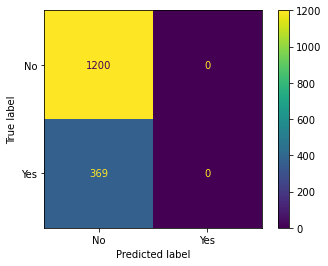

------------------------------------------------------------------------------------------------------------------------
50/50 [==============================] - 0s 3ms/step - loss: 0.3523 - accuracy: 0.8438
Test set accuracy=0.84385
Test set loss=0.352332
CONFUSION MATRIX FOR Model_6


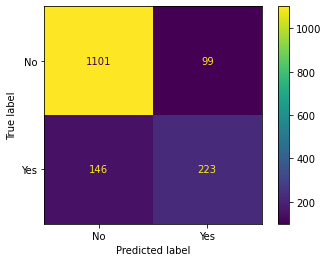

------------------------------------------------------------------------------------------------------------------------
50/50 [==============================] - 0s 4ms/step - loss: 0.5815 - accuracy: 0.7648
Test set accuracy=0.764818
Test set loss=0.581522
CONFUSION MATRIX FOR Model_7


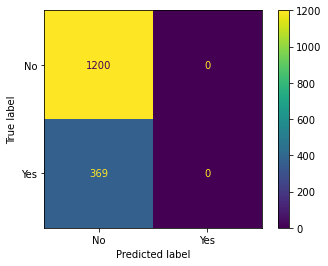

In [39]:
models = [model1, model2, model3 , model4, model5, model6, model7]

for i,model in enumerate(models) :
    print("---------------"*8)
    # First load the "optimal" weigts found during training 
    model.load_weights(f'Net_Weights/Neural_Net{i+1}.h5')
    test_loss, test_acc = model.evaluate(X_test_tensors, y_test)
    print(f"Test set accuracy={round(test_acc,6)}")
    print(f"Test set loss={round(test_loss,6)}")
    
    print(f"CONFUSION MATRIX FOR Model_{i+1}")
    y_pred = model.predict(X_test_tensors)
    cm = confusion_matrix(y_test, np.round(y_pred), labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['No', 'Yes'])
    disp.plot()
    plt.show()